# Non-prompt fraction of KS and Lambda particles from hyperon decays

A particle is prompt, if it does not have particles in its decay history with life-times larger than 30 ps. According to this definition, some Lambda particles are not prompt, since a fraction of Xi and Omega decays produce Lambda particles, and Xi and Omega particles have life-times larger than 30 ps. We compute the fraction of KS and Lambda particles that are non-prompt. For the KS, we do not find any, but for Lambdas the feed-down is quite large.

We select KS and Lambdas only if they decay into two pions or one pions and one protons, respectively, and if those daughter particles are in the LHCb acceptance 2 < η < 5 and $p > 2$GeV/c. Since the LHCb acceptance also implicitly places a cut on the position of the decay vertex of the KS or Lambda, we also record it.

In [1]:
import matplotlib.pyplot as plt
import boost_histogram as bh
from tqdm import tqdm
from particle import literals as lp, Particle
import joblib  # only joblib works reliably in notebooks
import numpy as np

from chromo.kinematics import CenterOfMass, TeV, MeV, GeV
from chromo.constants import long_lived
import chromo.models as im
from chromo.util import pdg2name
import numba as nb
import gzip
import pickle
from pathlib import Path

In [2]:
# The event kinematics objects defines the collision and its frame.
ekin = CenterOfMass(
    2 * 6.8 * TeV,
    "proton",
    "proton"
)

In [3]:
pid_axis = bh.axis.IntCategory([x.pdgid for x in (lp.K_S_0, lp.Lambda, lp.Lambda_bar)])
parent_axis = bh.axis.IntCategory([], growth=True)
pt_axis = bh.axis.Variable([150, 500, 650, 800, 1000, 1200, 2500])
y_axis = bh.axis.Regular(5, 2, 4.5)
z_axis = bh.axis.Regular(100, 0, 2000)

models = [
    im.Sibyll23d,
    im.Pythia8,
    im.EposLHC
]

log_10_n_events = 6


@nb.njit
def select(pid, parents, eta, ptot, vz):
    keep = (310, 3122, -3122)

    keep_daughters = (211, 2212)
    with_accepted_daughters = {}
    decay_z = {}
    for i, pidi in enumerate(pid):
        if abs(pidi) not in keep_daughters:
            continue
        k = parents[i][0] - 1
        if pid[k] not in keep:
            continue
        if 2 < eta[i] < 5 and ptot[i] > 2 * GeV:
            if k not in with_accepted_daughters:
                with_accepted_daughters[k] = 1
                decay_z[k] = vz[i]
            else:
                with_accepted_daughters[k] += 1

    r = np.zeros_like(pid, dtype="bool")
    z = []
    for k, n in with_accepted_daughters.items():
        if n == 2:
            r[k] = True
            z.append(decay_z[k])
    return r, np.array(z)


@nb.njit
def pid_of_parent(parents, pids, status):
    r = np.zeros_like(pids)
    for i, pa in enumerate(parents):
        k = i
        # we expect that history is not deeper than 100 ancestors
        for _ in range(100):
            k = parents[k][0] - 1
            if k < 0 or status[k] == 4:
                break
            pid = pids[k]
            if pid in long_lived and status[k] != 4:
                r[i] = pid
                break
        else:
            # should never happen
            assert False
    return r


@joblib.delayed
def run(Model):
    m = Model(ekin, seed=1)

    target = [lp.pi_0, lp.K_S_0, lp.Lambda]
    target_mass = [p.mass for p in target]
    # let long-lived particles decay which are heavier than the lightest target particle
    for pid in long_lived:
        mass = Particle.from_pdgid(pid).mass
        if any(mass > m for m in target_mass):
            m.set_stable(pid, False)
    # let target particles decay
    for p in target:
        m.set_stable(p.pdgid, False)

    h = bh.Histogram(y_axis, pt_axis, pid_axis, parent_axis, z_axis)

    n_events = int(10 ** log_10_n_events)
    with np.errstate(divide="ignore", invalid="ignore"):
        for event in tqdm(m(n_events), total=n_events):
            mother_pid = pid_of_parent(event.parents, event.pid, event.status)
            mask, vz = select(event.pid, event.parents, event.eta, event.p_tot, event.vz)
            event = event[mask]
            mother_pid = mother_pid[mask]
            h.fill(event.y, event.pt / MeV, event.pid, mother_pid, vz)
    return m.label, h

fn = Path("feed_down_histograms.pkl.gz")
if not fn.exists():
    with joblib.Parallel(n_jobs=10, batch_size=1) as pool:
        results = pool(run(m) for m in models)

    results = {label: h for (label, h) in results}

    with gzip.open(fn, "w") as f:
        pickle.dump(results, f)
else:
    with gzip.open(fn) as f:
        results = pickle.load(f)

###################################################################
#        EPOS LHC      K. WERNER, T. PIEROG                       #
#                      Contact: tanguy.pierog@kit.edu             #
###################################################################
#        WARNING: This is a special retuned version !!!           #
 |                                                  |
#     Do not publish results without contacting the authors.      #
 |                 S I B Y L L  2.3d                |
 |                                                  |
 |         HADRONIC INTERACTION MONTE CARLO         |
 |                        BY                        |
 |            Eun-Joo AHN, Felix RIEHN              |
 |      R. ENGEL, A. FEDYNITCH, R.S. FLETCHER,      |
 |       T.K. GAISSER, P. LIPARI, T. STANEV         |
 |                                                  |
 | Publication to be cited when using this program: |
 | Eun-Joo AHN et al., Phys.Rev. D80 (2009) 094003  

 29%|██▉       | 288315/1000000 [03:02<06:51, 1730.64it/s]

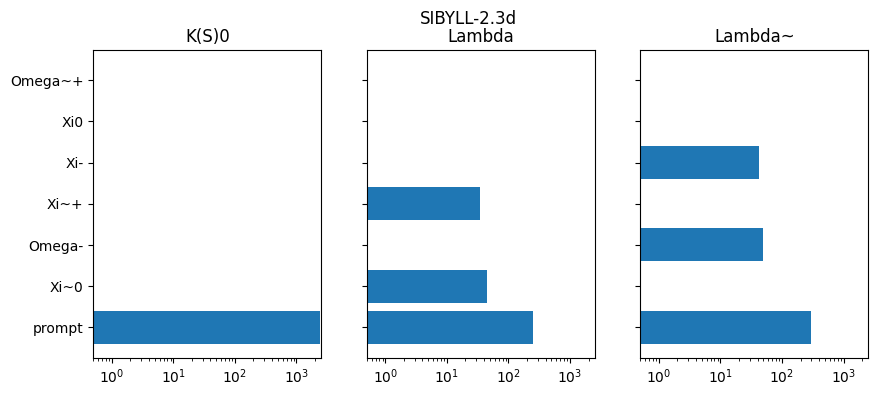

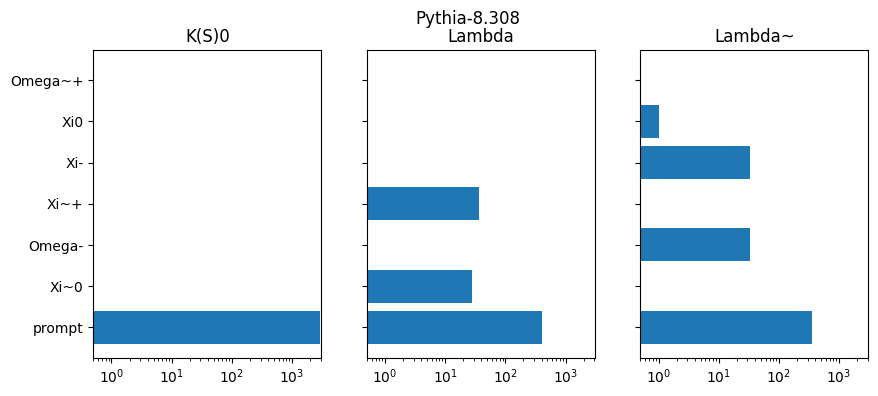

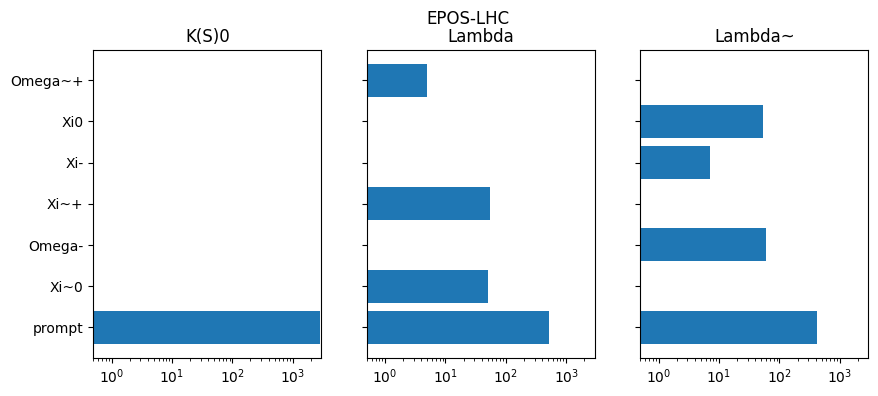

In [ ]:
mothers = set()
for model, h in results.items():
    for pid in h.axes[3]:
        mothers.add(pid)

for model, h in results.items():
    fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
    val = h.project(2, 3).values()
    plt.suptitle(model)
    for i, pid in enumerate(h.axes[2]):
        plt.sca(ax[i])
        plt.title(pdg2name(pid))
        v = np.zeros(len(mothers))
        for pid2 in mothers:
            try:
                k = h.axes[3].index(pid2)
                v[k] = val[i, k]
            except KeyError:
                pass
        y = np.arange(len(v))
        plt.barh(y, v)
        plt.yticks(y, [pdg2name(pid) if pid != 0 else "prompt" for pid in mothers])
        plt.xlim(0.5, None)
    plt.semilogx();

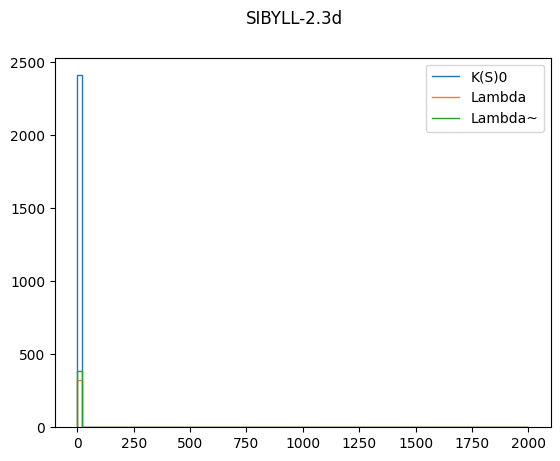

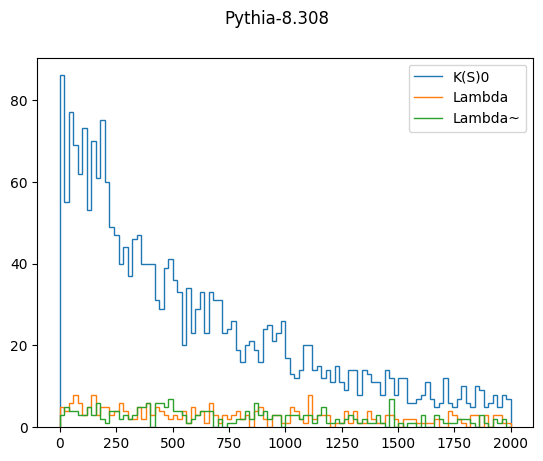

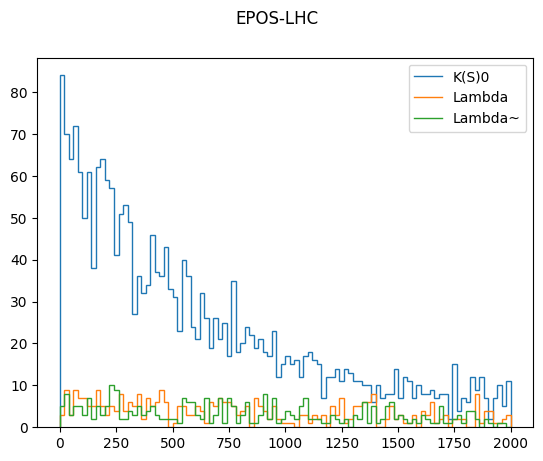

In [ ]:
for model, h in results.items():
    val = h.project(2, 4).values()
    plt.figure()
    plt.suptitle(model)
    for i, pid in enumerate(h.axes[2]):
        plt.stairs(val[i], h.axes[4].edges, label=pdg2name(pid))
    plt.legend()

/var/folders/tl/pv6mt7z17tz0stm1fjfg01cc0000gn/T/ipykernel_31759/777406361.py:11: RuntimeWarning: invalid value encountered in divide
  feed_down_fraction = 1 - n_prompt / n_total


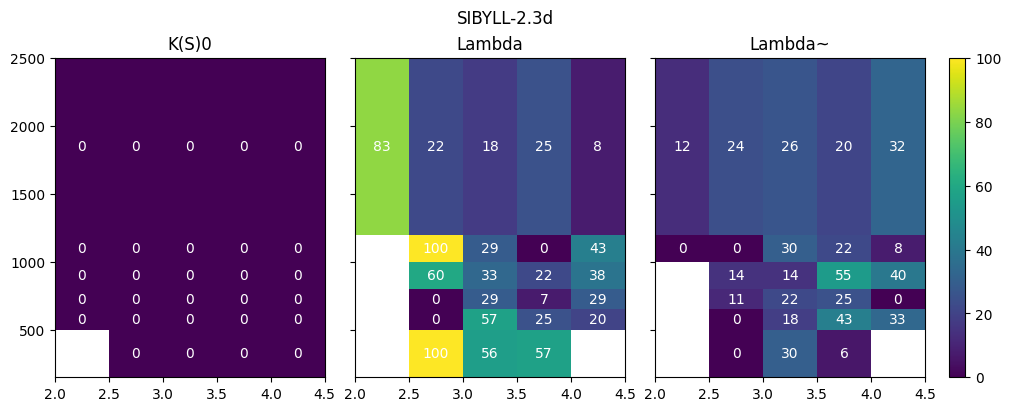

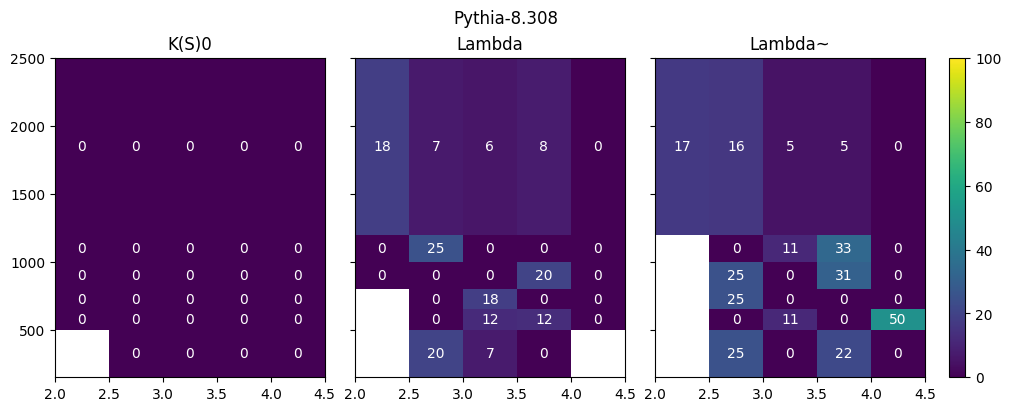

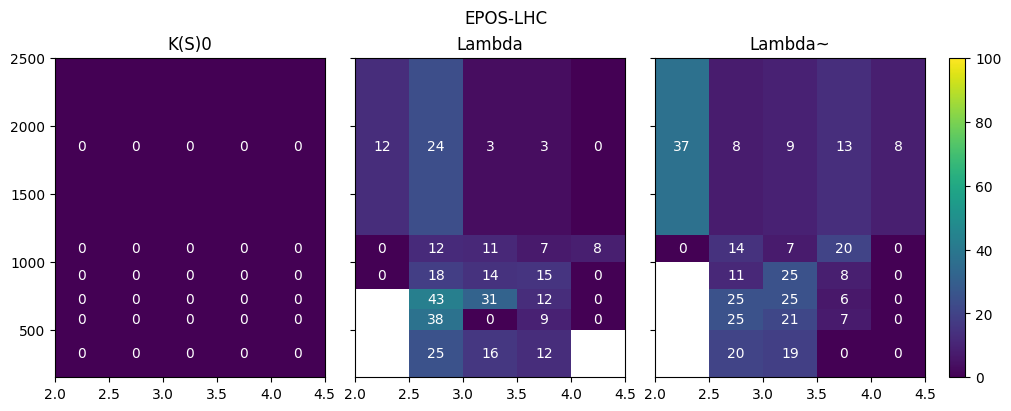

In [ ]:
for model, h in results.items():
    fig, ax = plt.subplots(1, 3, figsize=(10, 4), 
                           sharex=True, sharey=True, layout="compressed")
    plt.suptitle(model)
    for i, pid in enumerate(h.axes[2]):
        plt.sca(ax[i])
        plt.title(pdg2name(pid))
        val = np.sum(h.values()[:, :, i, :, :], axis=-1)
        n_total = np.sum(val, axis=-1)
        n_prompt = val[..., h.axes[3].index(0)]
        feed_down_fraction = 1 - n_prompt / n_total
        feed_down_fraction *= 100 # make percent
        plt.pcolormesh(h.axes[0].edges, h.axes[1].edges, feed_down_fraction.T)
        for i, x in enumerate(h.axes[0].centers):
            for j, y in enumerate(h.axes[1].centers):
                f = feed_down_fraction[i, j]
                plt.text(x, y, f"{f:.0f}", color="w", ha="center", va="center")
        plt.clim(0, 100)
    plt.colorbar()


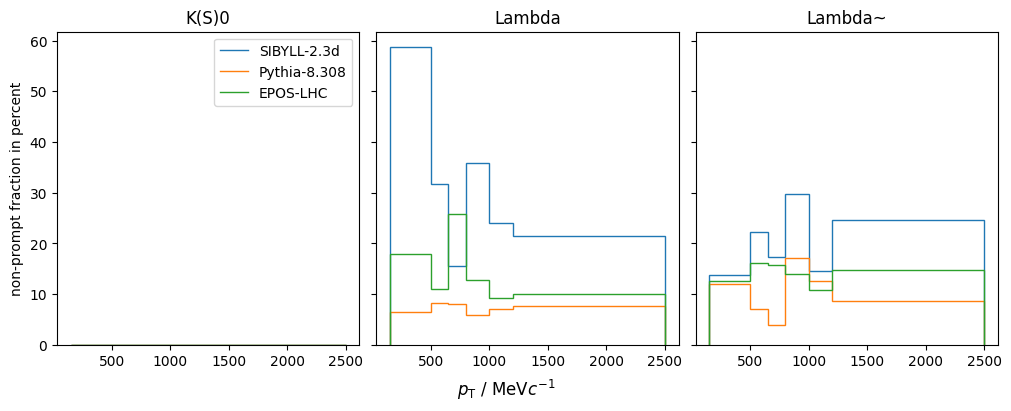

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), 
                       sharex=True, sharey=True, layout="compressed")

for model, h in results.items():
    for i, pid in enumerate(h.axes[2]):
        plt.sca(ax[i])
        plt.title(pdg2name(pid))
        val = np.sum(h.values()[:, :, i, :], axis=(0, -1))
        n_total = np.sum(val, axis=-1)
        n_prompt = val[..., h.axes[3].index(0)]
        feed_down_fraction = 1 - n_prompt / n_total
        feed_down_fraction *= 100 # make percent
        plt.stairs(feed_down_fraction, h.axes[1].edges, label=model)
plt.sca(ax[0])
plt.ylabel("non-prompt fraction in percent")
fig.supxlabel("$p_\mathrm{T}$ / MeV$c^{-1}$")
plt.legend();

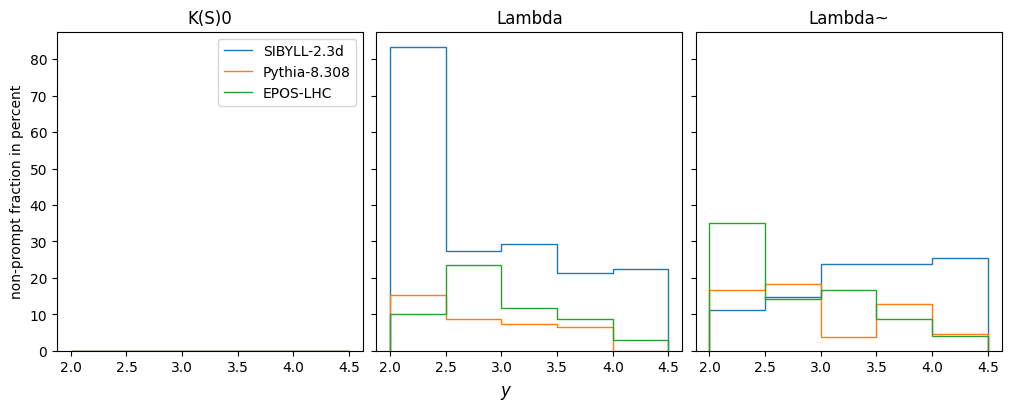

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), 
                       sharex=True, sharey=True, layout="compressed")

for model, h in results.items():
    for i, pid in enumerate(h.axes[2]):
        plt.sca(ax[i])
        plt.title(pdg2name(pid))
        val = np.sum(h.values()[:, :, i, :], axis=(1, -1))
        n_total = np.sum(val, axis=-1)
        n_prompt = val[..., h.axes[3].index(0)]
        feed_down_fraction = 1 - n_prompt / n_total
        feed_down_fraction *= 100 # make percent
        plt.stairs(feed_down_fraction, h.axes[0].edges, label=model)
plt.sca(ax[0])
plt.ylabel("non-prompt fraction in percent")
fig.supxlabel("$y$")
plt.legend();

/var/folders/tl/pv6mt7z17tz0stm1fjfg01cc0000gn/T/ipykernel_31759/729878470.py:14: RuntimeWarning: invalid value encountered in divide
  feed_down_fraction = 1 - n_prompt / n_total


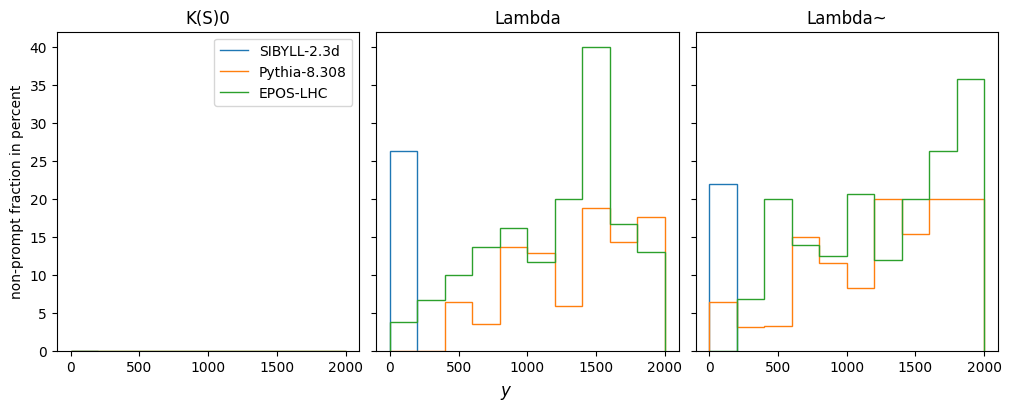

In [ ]:
# look feed-down fraction as function of z cut: 0 < z < 2m

fig, ax = plt.subplots(1, 3, figsize=(10, 4), 
                       sharex=True, sharey=True, layout="compressed")

for model, h in results.items():
    for i, pid in enumerate(h.axes[2]):
        plt.sca(ax[i])
        plt.title(pdg2name(pid))
        h2 = h[..., bh.rebin(10)]
        val = np.sum(h2.values()[:, :, i, :], axis=(0, 1))
        n_total = np.sum(val, axis=0)
        n_prompt = val[h2.axes[3].index(0)]
        feed_down_fraction = 1 - n_prompt / n_total
        feed_down_fraction *= 100 # make percent
        plt.stairs(feed_down_fraction, h2.axes[4].edges, label=model)
plt.sca(ax[0])
plt.ylabel("non-prompt fraction in percent")
fig.supxlabel("$y$")
plt.legend();